In this notebook Graph Nets library is used to learn to predict the motion of a set of masses conncted by springs.

The network is trained to predict the behaviour of a chain of five masses, connected by identical springs. The first and last masses are fixed; the others are subject to gravity.

In [1]:
import time

from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets.demos_tf2 import models
from matplotlib import pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import torch

import seaborn as sns

In [2]:
def base_graph(n, d):
  """Define a basic mass-spring system graph structure.

  These are n masses (1kg) connected by springs in a chain-like structure. The
  first and last masses are fixed. The masses are vertically aligned at the
  start and are d meters apart; this is also the rest length for the springs
  connecting them. Springs have spring constant 50 N/m and gravity is 10 N in
  the negative y-direction.

  Args:
    n: number of masses
    d: distance between masses (as well as springs' rest length)

  Returns:
    data_dict: dictionary with globals, nodes, edges, receivers and senders
        to represent a structure like the one above.
  """
  # Nodes
  # Generate initial position and velocity for all masses.
  # The left-most mass has is at position (0, 0); other masses (ordered left to
  # right) have x-coordinate d meters apart from their left neighbor, and
  # y-coordinate 0. All masses have initial velocity 0m/s.
  nodes = np.zeros((n, 5), dtype=np.float32)
  half_width = d * n / 2.0
  nodes[:, 0] = np.linspace(
      -half_width, half_width, num=n, endpoint=False, dtype=np.float32)
  # indicate that the first and last masses are fixed
  nodes[(0, -1), -1] = 1.

  # Edges.
  edges, senders, receivers = [], [], []
  for i in range(n - 1):
    left_node = i
    right_node = i + 1
    # The 'if' statements prevent incoming edges to fixed ends of the string.
    if right_node < n - 1:
      # Left incoming edge.
      edges.append([50., d])  #edges have 2 features, spring constant and spring length
      senders.append(left_node)
      receivers.append(right_node)
    if left_node > 0:
      # Right incoming edge.
      edges.append([50., d])
      senders.append(right_node)
      receivers.append(left_node)

  return {
      "globals": [0., -10.],
      "nodes": nodes,
      "edges": edges,
      "receivers": receivers,
      "senders": senders
  }

Each node has 5 features:
* x
* y
* v_x
* v_y
* is_fixed

In [3]:
base_graph_example=base_graph(10,2)
base_graph_example
#first and last mass send and edge, don't receive any edge

{'globals': [0.0, -10.0],
 'nodes': array([[-10.,   0.,   0.,   0.,   1.],
        [ -8.,   0.,   0.,   0.,   0.],
        [ -6.,   0.,   0.,   0.,   0.],
        [ -4.,   0.,   0.,   0.,   0.],
        [ -2.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  2.,   0.,   0.,   0.,   0.],
        [  4.,   0.,   0.,   0.,   0.],
        [  6.,   0.,   0.,   0.,   0.],
        [  8.,   0.,   0.,   0.,   1.]], dtype=float32),
 'edges': [[50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2],
  [50.0, 2]],
 'receivers': [1, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 8],
 'senders': [0, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 9]}

In [4]:
def hookes_law(receiver_nodes, sender_nodes, k, x_rest):
  """Applies Hooke's law to springs connecting some nodes.

  Args:
    receiver_nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for the
      receiver node of each edge.
    sender_nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for the
      sender node of each edge.
    k: Spring constant for each edge.
    x_rest: Rest length of each edge.

  Returns:
    Nx2 Tensor of the force [f_x, f_y] acting on each edge.
  """
  #compute the coordinates difference between receivers and senders
  diff = receiver_nodes[..., 0:2] - sender_nodes[..., 0:2]
  #compute the distance between receivers and senders
  x = tf.norm(diff, axis=-1, keepdims=True)
  
  force_magnitude = -1 * tf.multiply(k, (x - x_rest) / x)
  force = force_magnitude * diff
  return force

In [5]:
def euler_integration(nodes, force_per_node, step_size):
  """Applies one step of Euler integration.

  Args:
    nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each node.
    force_per_node: Ex2 tf.Tensor of the force [f_x, f_y] acting on each edge.
    step_size: Scalar.

  Returns:
    A tf.Tensor of dimension 2 and representing velocities of each node.
  """
  is_fixed = nodes[..., 4:5]
  # set forces to zero for fixed nodes
  force_per_node *= 1 - is_fixed
  new_vel = nodes[..., 2:4] + force_per_node * step_size
  return new_vel

In [39]:
class SpringMassSimulator(snt.Module):
  """Implements a basic Physics Simulator using the blocks library."""
  
  @snt.once
  def __init__(self, step_size, name="SpringMassSimulator"):
    super(SpringMassSimulator, self).__init__(name=name)
    self._step_size = step_size

    self._aggregator = blocks.ReceivedEdgesToNodesAggregator(
          reducer=tf.math.unsorted_segment_sum)

  def __call__(self, graph):
    """Builds a SpringMassSimulator.

    Args:
      graph: A graphs.GraphsTuple having, for some integers N, E, G:
          - edges: Nx2 tf.Tensor of [spring_constant, rest_length] for each
            edge.
          - nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each
            node.
          - globals: Gx2 tf.Tensor containing the gravitational constant.

    Returns:
      A graphs.GraphsTuple of the same shape as `graph`, but where:
          - edges: Holds the force [f_x, f_y] acting on each edge.
          - nodes: Holds velocities after applying one step of
              Euler integration.
    """
    receiver_nodes = blocks.broadcast_receiver_nodes_to_edges(graph)
    sender_nodes = blocks.broadcast_sender_nodes_to_edges(graph)

    spring_force_per_edge = hookes_law(receiver_nodes, sender_nodes,
                                       graph.edges[..., 0:1],
                                       graph.edges[..., 1:2])
    graph = graph.replace(edges=spring_force_per_edge)

    spring_force_per_node = self._aggregator(graph)
    gravity = blocks.broadcast_globals_to_nodes(graph)
    updated_velocities = euler_integration(
        graph.nodes, spring_force_per_node + gravity, self._step_size)
    graph = graph.replace(nodes=updated_velocities)
    return graph

In [7]:
def prediction_to_next_state(input_graph, predicted_graph, step_size):
  # manually integrate velocities to compute new position
  # predicted_graph.nodes cointain the velocities (2 dimensions array)
  # input_graph.nodes[..., :2] cointain initial position
  # new_pos has 2 dimensions
  new_pos = input_graph.nodes[..., :2] + predicted_graph.nodes * step_size

  # new_nodes has 5 dimensions ( position, velocity, is_fixed)
  new_nodes = tf.concat(
      [new_pos, predicted_graph.nodes, input_graph.nodes[..., 4:5]], axis=-1)
  return input_graph.replace(nodes=new_nodes)

In [8]:
def roll_out_physics(simulator, graph, steps, step_size):
  """Apply some number of steps of physical laws to an interaction network.

  Args:
    simulator: A SpringMassSimulator, or some module or callable with the same
      signature.
    graph: A graphs.GraphsTuple having, for some integers N, E, G:
        - edges: Nx2 tf.Tensor of [spring_constant, rest_length] for each edge.
        - nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each
          node.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    steps: An integer.
    step_size: Scalar.

  Returns:
    A pair of:
    - The graph, updated after `steps` steps of simulation;
    - A `steps+1`xNx5 tf.Tensor of the node features at each step.
  """

  def body(t, graph, nodes_per_step):
    predicted_graph = simulator(graph)
    if isinstance(predicted_graph, list):
      predicted_graph = predicted_graph[-1]
    graph = prediction_to_next_state(graph, predicted_graph, step_size)
    return t + 1, graph, nodes_per_step.write(t, graph.nodes)

# tf.TensorArray can create a dynamic sized tensor array

  nodes_per_step = tf.TensorArray(
      dtype=graph.nodes.dtype, size=steps + 1, element_shape=graph.nodes.shape)
  nodes_per_step = nodes_per_step.write(0, graph.nodes)

  _, g, nodes_per_step = tf.while_loop(
      lambda t, *unused_args: t <= steps,
      body,
      loop_vars=[1, graph, nodes_per_step])
  return g, nodes_per_step.stack()

How tf.whole_loop works:

tf.while_loop(
    
    cond,
    body,
    loop_vars,
    shape_invariants=None,
    parallel_iterations=10,
    back_prop=True,
    swap_memory=False,
    maximum_iterations=None,
    name=None
    
)

cond is a callable returning a boolean scalar tensor. body is a callable returning a (possibly nested) tuple, namedtuple or list of tensors of the same arity (length and structure) and types as loop_vars. loop_vars is a (possibly nested) tuple, namedtuple or list of tensors that is passed to both cond and body. cond and body both take as many arguments as there are loop_vars.

In [37]:
def apply_noise(graph, node_noise_level, edge_noise_level, global_noise_level):
  """Applies uniformly-distributed noise to a graph of a physical system.

  Noise is applied to:
  - the x and y coordinates (independently) of the nodes;
  - the spring constants of the edges;
  - the y coordinate of the global gravitational constant.

  Args:
    graph: a graphs.GraphsTuple having, for some integers N, E, G:
        - nodes: Nx5 Tensor of [x, y, _, _, _] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    node_noise_level: Maximum distance to perturb nodes' x and y coordinates.
    edge_noise_level: Maximum amount to perturb edge spring constants.
    global_noise_level: Maximum amount to perturb the Y component of gravity.

  Returns:
    The input graph, but with noise applied.
  """
  node_position_noise = tf.random.uniform(
      [graph.nodes.shape[0], 2],
      minval=-node_noise_level,
      maxval=node_noise_level)
    # dim(node_position_noise)= num_nodes x 2
  edge_spring_constant_noise = tf.random.uniform(
      [graph.edges.shape[0], 1],
      minval=-edge_noise_level,
      maxval=edge_noise_level)
    # dim(edge_spring_constant_noise)= num_edges x 1
  global_gravity_y_noise = tf.random.uniform(
      [graph.globals.shape[0], 1],
      minval=-global_noise_level,
      maxval=global_noise_level)
    # dim(global_gravity_y_noise)= num_graph x 1
    
  return graph.replace(
      nodes=tf.concat(
          [graph.nodes[..., :2] + node_position_noise, graph.nodes[..., 2:]],
          axis=-1),
      edges=tf.concat(
          [
              graph.edges[..., :1] + edge_spring_constant_noise,
              graph.edges[..., 1:]
          ],
          axis=-1),
      globals=tf.concat(
          [
              graph.globals[..., :1],
              graph.globals[..., 1:] + global_gravity_y_noise
          ],
          axis=-1))



In [10]:
def set_rest_lengths(graph):
  """Computes and sets rest lengths for the springs in a physical system.

  The rest length is taken to be the distance between each edge's nodes.

  Args:
    graph: a graphs.GraphsTuple having, for some integers N, E:
        - nodes: Nx5 Tensor of [x, y, _, _, _] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.

  Returns:
    The input graph, but with [spring_constant, rest_length] for each edge.
  """
  receiver_nodes = blocks.broadcast_receiver_nodes_to_edges(graph)
  sender_nodes = blocks.broadcast_sender_nodes_to_edges(graph)
  #compute the distance between each couple of nodes
  rest_length = tf.norm(
      receiver_nodes[..., :2] - sender_nodes[..., :2], axis=-1, keepdims=True)
  #set the spring length as second feature of each edge
  return graph.replace(
      edges=tf.concat([graph.edges[..., :1], rest_length], axis=-1))


In [11]:
def generate_trajectory(simulator, graph, steps, step_size, node_noise_level,
                        edge_noise_level, global_noise_level):
  """Applies noise and then simulates a physical system for a number of steps.

  Args:
    simulator: A SpringMassSimulator, or some module or callable with the same
      signature.
    graph: a graphs.GraphsTuple having, for some integers N, E, G:
        - nodes: Nx5 Tensor of [x, y, v_x, v_y, is_fixed] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    steps: Integer; the length of trajectory to generate.
    step_size: Scalar.
    node_noise_level: Maximum distance to perturb nodes' x and y coordinates.
    edge_noise_level: Maximum amount to perturb edge spring constants.
    global_noise_level: Maximum amount to perturb the Y component of gravity.

  Returns:
    A pair of:
    - The input graph, but with rest lengths computed and noise applied.
    - A `steps+1`xNx5 tf.Tensor of the node features at each step.
  """
  graph = apply_noise(graph, node_noise_level, edge_noise_level,
                      global_noise_level)
  graph = set_rest_lengths(graph)
  _, n = roll_out_physics(simulator, graph, steps, step_size)
  return graph, n

In [12]:
def create_loss_ops(target_op, output_ops):
  """Create supervised loss operations from targets and outputs.

  Args:
    target_op: The target velocity tf.Tensor.
    output_ops: The list of output graphs from the model.

  Returns:
    A list of loss values (tf.Tensor), one per output op.
  """
  loss_ops = [
      tf.reduce_mean(
          tf.reduce_sum((output_op.nodes - target_op[..., 2:4])**2, axis=-1))
      for output_op in output_ops
  ]
  return loss_ops

In [13]:
# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input mass-spring systems are
# procedurally generated, where the nodes represent the positions, velocities,
# and indicators of whether the mass is fixed in space or free to move, the
# edges represent the spring constant and spring rest length, and the global
# attribute represents the variable coefficient of gravitational acceleration.
# The outputs/targets have the same structure, with the nodes representing the
# masses' next-step states.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to systems which are one mass
# larger, and smaller, than those from the training distribution. The loss is
# computed as the mean over a 50-step rollout, where each step's input is the
# the previous step's output.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 10000-20000 training iterations the model reaches good
# performance on mass-spring systems with 5-8 masses.

In [40]:
SEED = 1

rand = np.random.RandomState(SEED)

# Model parameters.
num_processing_steps_tr = 1
num_processing_steps_ge = 1

# Data / training parameters.
num_training_iterations = 100000
batch_size_tr = 256
batch_size_ge = 100
num_time_steps = 50
step_size = 0.1
num_masses_min_max_tr = (5, 9)
dist_between_masses_min_max_tr = (0.2, 1.0)

# Create the model.
model = models.EncodeProcessDecode(node_output_size=2)


# Data.
# Base graphs for training.
num_masses_tr = rand.randint(*num_masses_min_max_tr, size=batch_size_tr)
dist_between_masses_tr = rand.uniform(
    *dist_between_masses_min_max_tr, size=batch_size_tr)
static_graph_tr = [
    base_graph(n, d) for n, d in zip(num_masses_tr, dist_between_masses_tr)
]
base_graph_tr = utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)


# Base graphs for testing.
# 4 masses 1m apart in a chain like structure.
base_graph_4_ge = utils_tf.data_dicts_to_graphs_tuple(
    [base_graph(4, 0.5)] * batch_size_ge)
# 9 masses 0.5m apart in a chain like structure.
base_graph_9_ge = utils_tf.data_dicts_to_graphs_tuple(
    [base_graph(9, 0.5)] * batch_size_ge)


# True physics simulator for data generation.
simulator = SpringMassSimulator(step_size=step_size)

# Training.
# Generate a training trajectory by adding noise to initial
# position, spring constants and gravity
initial_conditions_tr, true_trajectory_tr = generate_trajectory(
    simulator,
    base_graph_tr,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)

# initial_conditions_tr is equal to base_graph_tr + noise
# true_trajectory_tr is a tensor not a graphtuple
    


In [58]:
true_trajectory_tr.shape

TensorShape([51, 1641, 5])

In [93]:
# Random start step.
t = tf.random.uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
#take the graph at step t of the true_trajectory_tr
input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
# target nodes features are the one of the time step t+1
target_nodes_tr = true_trajectory_tr[t + 1]
# output node features are the one outputted by the model 
output_ops_tr = model(input_graph_tr, num_processing_steps_tr)
#outpurt size 2

In [94]:
print(type(input_graph_tr))

<class 'graph_nets.graphs.GraphsTuple'>


In [67]:
# Test data: 4-mass string.
initial_conditions_4_ge, true_trajectory_4_ge = generate_trajectory(
    lambda x: model(x, num_processing_steps_ge),
    base_graph_4_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)

_, true_nodes_rollout_4_ge = roll_out_physics(
    simulator, initial_conditions_4_ge, num_time_steps, step_size)
    
_, predicted_nodes_rollout_4_ge = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_4_ge,
    num_time_steps, step_size)

# Test data: 9-mass string.
initial_conditions_9_ge, true_trajectory_9_ge = generate_trajectory(
    lambda x: model(x, num_processing_steps_ge),
    base_graph_9_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)

_, true_nodes_rollout_9_ge = roll_out_physics(
    simulator, initial_conditions_9_ge, num_time_steps, step_size)
    
_, predicted_nodes_rollout_9_ge = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_9_ge,
    num_time_steps, step_size)

In [80]:
# Training loss.
loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)

# Training loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr

# Test/generalization loss: 4-mass.
loss_op_4_ge = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_4_ge[..., 2:4] -
         true_nodes_rollout_4_ge[..., 2:4])**2,
        axis=-1))
# Test/generalization loss: 9-mass string.
loss_op_9_ge = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_9_ge[..., 2:4] -
         true_nodes_rollout_9_ge[..., 2:4])**2,
        axis=-1))

# Optimizer.
learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)
#step_op = optimizer.minimize(loss_op_tr,model.trainable_variables)

#input_graph_tr = make_all_runnable_in_session(input_graph_tr)
#initial_conditions_4_ge = make_all_runnable_in_session(initial_conditions_4_ge)
# = make_all_runnable_in_session(initial_conditions_9_ge)

In [83]:
last_iteration = 0
logged_iterations = []
losses_tr = []
losses_4_ge = []
losses_9_ge = []

In [103]:
@tf.function
def get_data():
    # Data.
    # Base graphs for training.
    num_masses_tr = rand.randint(*num_masses_min_max_tr, size=batch_size_tr)
    dist_between_masses_tr = rand.uniform(
        *dist_between_masses_min_max_tr, size=batch_size_tr)
    static_graph_tr = [
        base_graph(n, d) for n, d in zip(num_masses_tr, dist_between_masses_tr)
    ]
    base_graph_tr = utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)

    # Base graphs for testing.
    # 4 masses 1m apart in a chain like structure.
    base_graph_4_ge = utils_tf.data_dicts_to_graphs_tuple(
        [base_graph(4, 0.5)] * batch_size_ge)
    # 9 masses 0.5m apart in a chain like structure.
    base_graph_9_ge = utils_tf.data_dicts_to_graphs_tuple(
        [base_graph(9, 0.5)] * batch_size_ge)

    initial_conditions_tr, true_trajectory_tr = generate_trajectory(
    simulator,
    base_graph_tr,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)
    
    # Random start step.
    t = tf.random.uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
    #take the graph at step t of the true_trajectory_tr
    input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
    # target nodes features are the one of the time step t+1
    target_nodes_tr = true_trajectory_tr[t + 1]
    # output node features are the one outputted by the model 
    #output_ops_tr = model(input_graph_tr, num_processing_steps_tr)
    #outpurt size 2
    # Test data: 4-mass string.
    initial_conditions_4_ge, true_trajectory_4_ge = generate_trajectory(
        lambda x: model(x, num_processing_steps_ge),
        base_graph_4_ge,
        num_time_steps,
        step_size,
        node_noise_level=0.04,
        edge_noise_level=5.0,
        global_noise_level=1.0)
    
    _, true_nodes_rollout_4_ge = roll_out_physics(
        simulator, initial_conditions_4_ge, num_time_steps, step_size)
        
    _, predicted_nodes_rollout_4_ge = roll_out_physics(
        lambda x: model(x, num_processing_steps_ge), initial_conditions_4_ge,
        num_time_steps, step_size)
    
    # Test data: 9-mass string.
    initial_conditions_9_ge, true_trajectory_9_ge = generate_trajectory(
        lambda x: model(x, num_processing_steps_ge),
        base_graph_9_ge,
        num_time_steps,
        step_size,
        node_noise_level=0.04,
        edge_noise_level=5.0,
        global_noise_level=1.0)
    
    _, true_nodes_rollout_9_ge = roll_out_physics(
        simulator, initial_conditions_9_ge, num_time_steps, step_size)
        
    _, predicted_nodes_rollout_9_ge = roll_out_physics(
        lambda x: model(x, num_processing_steps_ge), initial_conditions_9_ge,
        num_time_steps, step_size)
    
    return input_graph_tr,target_nodes_tr,true_nodes_rollout_4_ge,predicted_nodes_rollout_4_ge,true_nodes_rollout_9_ge,predicted_nodes_rollout_9_ge
    

In [108]:
# Training.
def update_step(inputs_tr, targets_tr):
  #print(type(inputs_tr))
  with tf.GradientTape() as tape:
    outputs_tr = model(inputs_tr, num_processing_steps_tr)
    # Loss.
    loss_tr = create_loss_ops(targets_tr, outputs_tr)
    loss_tr = tf.math.reduce_sum(loss_tr) / num_processing_steps_tr

  gradients = tape.gradient(loss_tr, model.trainable_variables)
  optimizer.apply(gradients, model.trainable_variables)
  return outputs_tr, loss_tr

In [109]:
example_input_data, example_target_data = get_data()[:2]
print(type(example_input_data))
print(type(example_target_data))
# Get the input signature for that function by obtaining the specs
input_signature = [
  utils_tf.specs_from_graphs_tuple(example_input_data),
  tf.TensorSpec(tf.shape(example_target_data))
]

# Compile the update function using the input signature for speedy code.
compiled_update_step = tf.function(update_step, input_signature=input_signature)

<class 'graph_nets.graphs.GraphsTuple'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [111]:
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), "
      "Lge4 (test/generalization rollout loss for 4-mass strings), "
      "Lge9 (test/generalization rollout loss for 9-mass strings)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
      last_iteration = iteration
  

      (input_graph_tr,target_nodes_tr,true_nodes_rollout_4_ge,
      predicted_nodes_rollout_4_ge,true_nodes_rollout_9_ge,
      predicted_nodes_rollout_9_ge)=get_data()

      outputs_tr, loss_tr=compiled_update_step(input_graph_tr,target_nodes_tr)
      
      the_time = time.time()
      elapsed_since_last_log = the_time - last_log_time
      if elapsed_since_last_log > log_every_seconds:
            last_log_time = the_time

            loss_op_4_ge = tf.reduce_mean(
                              tf.reduce_sum(
                                    (predicted_nodes_rollout_4_ge[..., 2:4] -
                                     true_nodes_rollout_4_ge[..., 2:4])**2,
                                     axis=-1))

            loss_op_9_ge = tf.reduce_mean(
                              tf.reduce_sum(
                                    (predicted_nodes_rollout_9_ge[..., 2:4] -
                                     true_nodes_rollout_9_ge[..., 2:4])**2,
                                     axis=-1))

            elapsed = time.time() - start_time

            logged_iterations.append(iteration)
            losses_tr.append(loss_tr.numpy())
            losses_4_ge.append(loss_op_4_ge.numpy())
            losses_9_ge.append(loss_op_9_ge.numpy())
            print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge4 {:.4f}, Lge9 {:.4f}".format(
                  iteration, elapsed, loss_tr.numpy(), loss_op_4_ge.numpy(),
                  loss_op_9_ge.numpy()))
            



# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), Lge4 (test/generalization rollout loss for 4-mass strings), Lge9 (test/generalization rollout loss for 9-mass strings)
# 00468, T 20.0, Ltr 1.5527, Lge4 2.7803, Lge9 14.2191
# 00673, T 40.0, Ltr 1.3054, Lge4 1.7573, Lge9 15.6838
# 00858, T 60.1, Ltr 1.1421, Lge4 2.4119, Lge9 12.0689
# 01061, T 80.1, Ltr 1.0345, Lge4 4.6376, Lge9 10.4315
# 01254, T 100.2, Ltr 0.0868, Lge4 2.1937, Lge9 16.8742
# 01447, T 120.3, Ltr 0.2030, Lge4 1.9879, Lge9 15.4008
# 01627, T 140.3, Ltr 0.9994, Lge4 2.6915, Lge9 11.4843
# 01822, T 160.4, Ltr 0.9389, Lge4 2.9047, Lge9 9.3382
# 02015, T 180.4, Ltr 0.7957, Lge4 2.1285, Lge9 9.0672
# 02199, T 200.5, Ltr 0.3328, Lge4 2.0953, Lge9 6.9549
# 02390, T 220.6, Ltr 0.8850, Lge4 2.4981, Lge9 8.0300
# 02571, T 240.6, Ltr 0.7680, Lge4 3.1820, Lge9 8.6654
# 02733, T 260.6, Ltr 0.5603, Lge4 2.4811, Lge9 5.3345
# 02899, T 280.6, Ltr 0.1048, Lge4 2.2733, Lge9 10.1139
# 03080, T 300.7, Ltr 0.8647, Lge4 1

KeyboardInterrupt: 

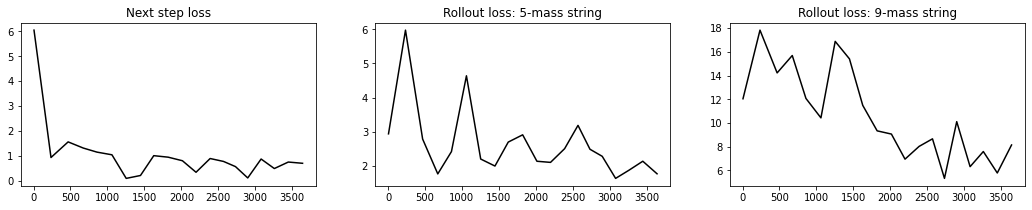

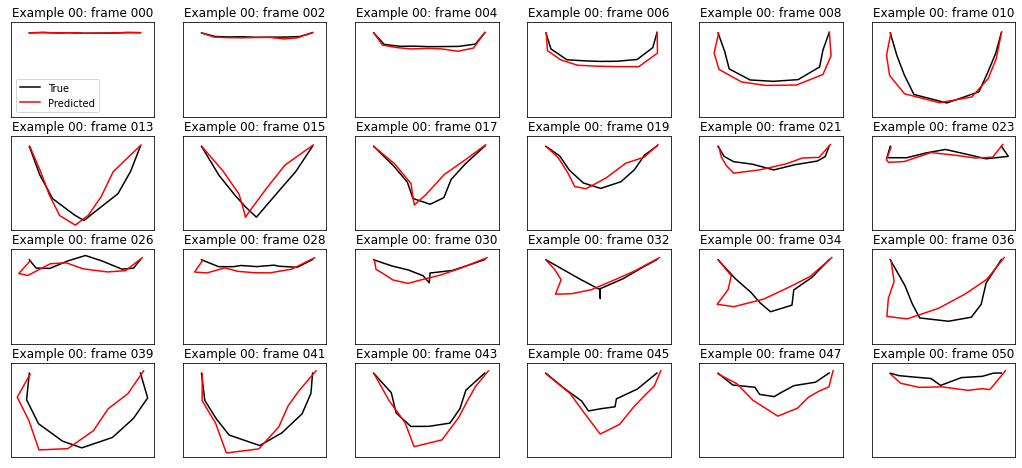

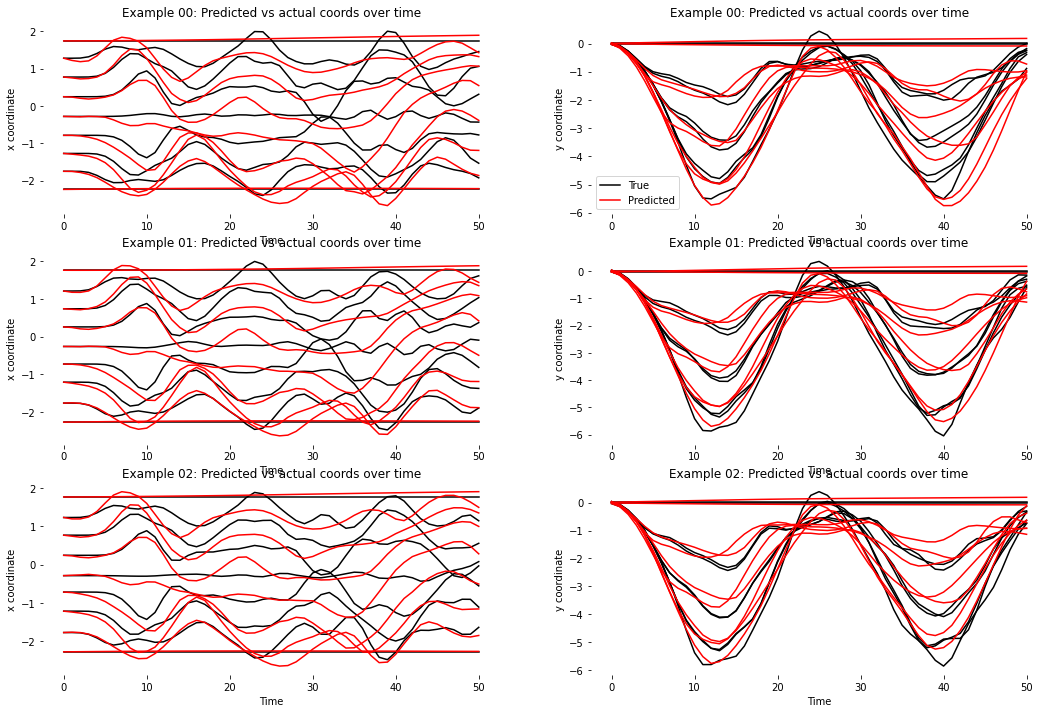

In [113]:
def get_node_trajectories(rollout_array, batch_size):  # pylint: disable=redefined-outer-name
  return np.split(rollout_array[..., :2], batch_size, axis=1)


fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Next-step Loss.
y = losses_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Next step loss")
# Rollout 5 loss.
y = losses_4_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 5-mass string")
# Rollout 9 loss.
y = losses_9_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 9-mass string")

# Visualize trajectories.
true_rollouts_4 = get_node_trajectories(true_nodes_rollout_4_ge,
                                        batch_size_ge)
predicted_rollouts_4 = get_node_trajectories(predicted_nodes_rollout_4_ge,
                                             batch_size_ge)
true_rollouts_9 = get_node_trajectories(true_nodes_rollout_9_ge,
                                        batch_size_ge)
predicted_rollouts_9 = get_node_trajectories(predicted_nodes_rollout_9_ge,
                                             batch_size_ge)

true_rollouts = true_rollouts_4
predicted_rollouts = predicted_rollouts_4
true_rollouts = true_rollouts_9
predicted_rollouts = predicted_rollouts_9

num_graphs = len(true_rollouts)
num_time_steps = true_rollouts[0].shape[0]

# Plot state sequences.
max_graphs_to_plot = 1
num_graphs_to_plot = min(num_graphs, max_graphs_to_plot)
num_steps_to_plot = 24
max_time_step = num_time_steps - 1
step_indices = np.floor(np.linspace(0, max_time_step,
                                    num_steps_to_plot)).astype(int).tolist()
w = 6
h = int(np.ceil(num_steps_to_plot / w))
fig = plt.figure(101, figsize=(18, 8))
fig.clf()
for i, (true_rollout, predicted_rollout) in enumerate(
    zip(true_rollouts, predicted_rollouts)):
  xys = np.hstack([predicted_rollout, true_rollout]).reshape([-1, 2])
  xs = xys[:, 0]
  ys = xys[:, 1]
  b = 0.05
  xmin = xs.min() - b * xs.ptp()
  xmax = xs.max() + b * xs.ptp()
  ymin = ys.min() - b * ys.ptp()
  ymax = ys.max() + b * ys.ptp()
  if i >= num_graphs_to_plot:
    break
  for j, step_index in enumerate(step_indices):
    iax = i * w + j + 1
    ax = fig.add_subplot(h, w, iax)
    ax.plot(
        true_rollout[step_index, :, 0],
        true_rollout[step_index, :, 1],
        "k",
        label="True")
    ax.plot(
        predicted_rollout[step_index, :, 0],
        predicted_rollout[step_index, :, 1],
        "r",
        label="Predicted")
    ax.set_title("Example {:02d}: frame {:03d}".format(i, step_index))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.legend(loc=3)

# Plot x and y trajectories over time.
max_graphs_to_plot = 3
num_graphs_to_plot = min(len(true_rollouts), max_graphs_to_plot)
w = 2
h = num_graphs_to_plot
fig = plt.figure(102, figsize=(18, 12))
fig.clf()
for i, (true_rollout, predicted_rollout) in enumerate(
    zip(true_rollouts, predicted_rollouts)):
  if i >= num_graphs_to_plot:
    break
  t = np.arange(num_time_steps)
  for j in range(2):
    coord_string = "x" if j == 0 else "y"
    iax = i * 2 + j + 1
    ax = fig.add_subplot(h, w, iax)
    ax.plot(t, true_rollout[..., j], "k", label="True")
    ax.plot(t, predicted_rollout[..., j], "r", label="Predicted")
    ax.set_xlabel("Time")
    ax.set_ylabel("{} coordinate".format(coord_string))
    ax.set_title("Example {:02d}: Predicted vs actual coords over time".format(
        i))
    ax.set_frame_on(False)
    if i == 0 and j == 1:
      handles, labels = ax.get_legend_handles_labels()
      unique_labels = []
      unique_handles = []
      for i, (handle, label) in enumerate(zip(handles, labels)):  # pylint: disable=redefined-outer-name
        if label not in unique_labels:
          unique_labels.append(label)
          unique_handles.append(handle)
      ax.legend(unique_handles, unique_labels, loc=3)